[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nkeriven/ensta-mt12/blob/main/notebooks/08_RNN_LSTM/N3_MAB.ipynb)

Inspired by https://github.com/akhadangi/Multi-armed-Bandits

We are going to implement simple Eps-greedy and UCB and test them on synthetic data.

In [141]:

# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

Let's first define a Bandit

In [142]:
class Bandit:
    def __init__(self, r_values, sigma=1):
        self.r_values = r_values
        self.sigma = sigma
    def get_reward(self, arm):
        return np.abs(self.r_values[arm] + self.sigma*np.random.randn())

Let us now define algorithm for bandits. We will first define a base class with common methods, then instanciate it for several algorithms.

This is how we implement an **abstract class** in Python. Basically a class that serve as a common superclass for other classes, and that cannot be instanciated on its own

In [143]:
class MAB(ABC):
    
    @abstractmethod
    def __init__(self, narms):
        self.narms = narms
        self.step_n = 0
        self.step_arm = np.zeros(narms)
        self.AM_reward = np.zeros(narms)
    
    @abstractmethod
    def play(self, r_values):
        # choose an arm which yields maximum value of average mean reward, tie breaking randomly
        chosen_arm = np.random.choice(np.where(r_values==r_values.max())[0])
        return chosen_arm
        
    
    @abstractmethod
    def update(self, arm, reward):
        # update the overall step of the model
        self.step_n += 1
        # update the step of individual arms
        self.step_arm[arm] += 1
        # update average mean reward of each arm
        self.AM_reward[arm] = ((self.step_arm[arm] - 1) / float(self.step_arm[arm]) 
        * self.AM_reward[arm] + (1 / float(self.step_arm[arm])) * reward)
        return
        pass


In [144]:
class EpsGreedy(MAB): # this class inherits from MAB
    
    def __init__(self, narms, epsilon):
        super().__init__(narms)
        # Exploration probability
        self.epsilon = epsilon
        # To play each arm at least once
        self.already_played = np.zeros(narms)
        
        return
        
    # Play one round and return the action (chosen arm)
    def play(self):
        # Generate random number
        p = np.random.rand()
        
        if p < self.epsilon:
            action = np.random.choice(self.narms)
        else:

            if self.already_played.sum()<self.narms:
                # if there are arms never played yet, draw one of them
                action = np.random.choice(np.where(self.already_played==0)[0])
                self.already_played[action]=1
            else:
                action = super().play(self.AM_reward)
        return action
    
        
    def update(self, arm, reward):
        super().update(arm, reward)
        return

Let's test epsilon-greedy algo against the best policy.

In [145]:
r_val = 3*np.random.rand(10)
sigma = 1
epsg = EpsGreedy(len(r_val), .8)
bandit = Bandit(r_val, sigma)
R = 100
r_eps = [0]
r_best = [0]
for r in range(R):
    arm_eps = epsg.play()
    eps_rew = bandit.get_reward(arm_eps)
    r_eps.append(r_eps[-1] + eps_rew)
    epsg.update(arm_eps, eps_rew)
    
    best_rew = bandit.get_reward(np.argmax(r_val, axis=0))
    r_best.append(r_best[-1] + best_rew)

In [146]:
print(epsg.AM_reward)

[2.05349452 0.79971166 2.08269922 1.09237491 0.89740344 1.51653017
 1.44012596 1.0008131  0.89649974 0.79596894]


In [147]:
r_val

array([2.08268307, 0.50621539, 2.48203609, 0.55608481, 0.01517415,
       1.12837074, 0.87743495, 0.39436744, 0.9787888 , 0.34231758])

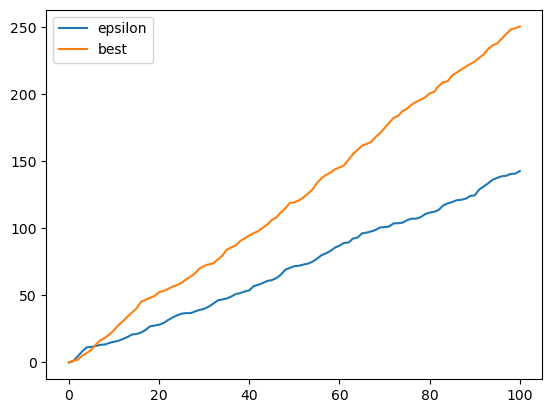

In [148]:
plt.plot(r_eps, label='epsilon')
plt.plot(r_best, label='best')
plt.legend()

Play with epsilon and the r_value a bit. Draw a curve wrt epsilon

### UCB

Let's implement UCB. This is just a change in how we draw arm.

In [149]:

class UCB(MAB): # this class inherits from MAB
    
    def __init__(self, narms, rho=1):
        super().__init__(narms)
        # To play each arm at least once
        self.already_played = np.zeros(narms)
        self.rho=rho
        
        return
        
    # Play one round and return the action (chosen arm)
    def play(self):
        if self.already_played.sum()<self.narms:
            # if there are arms never played yet, draw one of them
            action = np.random.choice(np.where(self.already_played==0)[0])
            self.already_played[action]=1
        else:
            ucb_values = self.AM_reward + np.sqrt(self.rho *(np.log(self.step_n)) / self.step_arm)
            action = super().play(ucb_values)
        return action
    
        
    def update(self, arm, reward):
        super().update(arm, reward)
        return

In [161]:
r_val = 3*np.random.rand(15)
sigma = 1
epsg = EpsGreedy(len(r_val), epsilon = .8)
ucb = UCB(len(r_val))
bandit = Bandit(r_val, sigma)
R = 150
r_eps = [0]
r_ucb = [0]
r_best = [0]
for r in range(R):
    arm_eps = epsg.play()
    eps_rew = bandit.get_reward(arm_eps)
    r_eps.append(r_eps[-1] + eps_rew)
    epsg.update(arm_eps, eps_rew)
    
    arm_ucb = ucb.play()
    ucb_rew = bandit.get_reward(arm_ucb)
    r_ucb.append(r_ucb[-1] + ucb_rew)
    ucb.update(arm_ucb, ucb_rew)
    
    best_rew = bandit.get_reward(np.argmax(r_val, axis=0))
    r_best.append(r_best[-1] + best_rew)

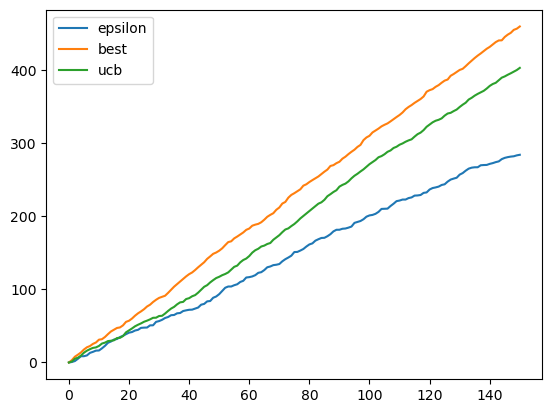

In [162]:
plt.plot(r_eps, label='epsilon')
plt.plot(r_best, label='best')
plt.plot(r_ucb, label='ucb')
plt.legend()

Play with the parameters of the problem. What do you observe ?